In [7]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

import exoplanet as xo
from specgp.terms import KronTerm
from specgp.means import KronMean
from specgp.distributions import MvUniform

Start by loading the traces from our MCMC analysis of the SOHO data:

In [8]:
with pm.Model() as model:
    trace = pm.load_trace('../../docs/tutorials/.pymc_3.trace')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)

Load SOHO data:

In [33]:
from astropy.io import fits
from astropy.time import Time

blue = fits.open('../../specgp/soho/blue.fits')
green = fits.open('../../specgp/soho/green.fits')
red = fits.open('../../specgp/soho/red.fits')
rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
i = 98765
n = 1000
t = t[i:i+n] - np.mean(t[i:i+n])
# in units of parts per thousand 
rgb = [f[i:i+n]/1e3 for f in rgb]

# add artificial white noise to the SOHO data in order 
# to make the model numerically stable.
rgb += np.random.randn(3, n) * np.exp(-4)

Plot it:

Text(0.025, 0.4, 'normalized flux')

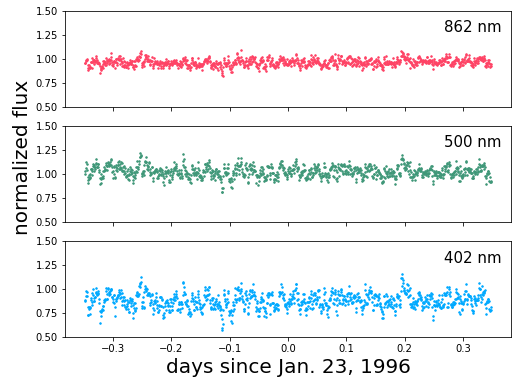

In [35]:
fig, ax = pl.subplots(3, 1, figsize=(8, 6), sharex=True)
bands = ['862 nm', '500 nm', '402 nm']

[a.plot(t, 1+f, '.', color=colors[i], ms=3.0) for i, (a, f) in enumerate(zip(ax, rgb))]
[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
[ax.set_ylim(0.5, 1.5) for ax in ax]

ax[2].set_xlabel('days since Jan. 23, 1996', fontsize=20)
pl.annotate("normalized flux", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

Add a transit with ``starry``:

In [36]:
orbit = xo.orbits.KeplerianOrbit(period=5.0)
u = [0.3, 0.2]
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.009, t=t, texp=0.02)
    .eval()
).T[0] * 1e3
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.002, t=t+0.25, texp=0.02)
    .eval()
).T[0] * 1e3

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


[Text(0.5, 0, 'time (days)'), Text(0.5, 0, 'time (days)')]

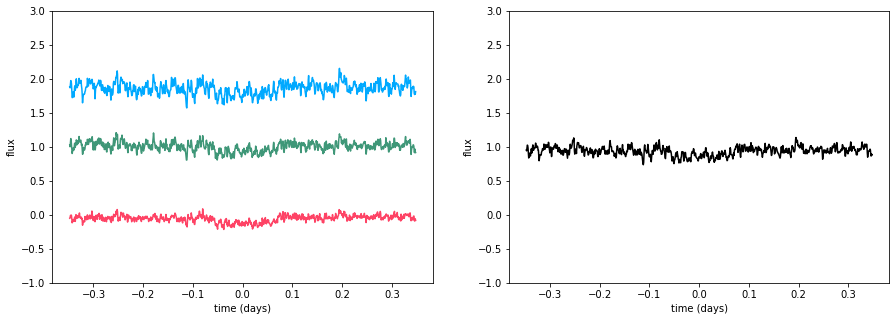

In [37]:
fig, ax = pl.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t, rgb[0] + planet + moon, '-', color=colors[0])
ax[0].plot(t, rgb[1]+1 + planet + moon, '-', color=colors[1])
ax[0].plot(t, rgb[2]+2 + planet + moon, '-', color=colors[2])
ax[0].set_ylim(-1, 3)

ax[1].plot(t, np.mean(rgb, axis=0)+1 + planet, '-', color='k')
ax[1].set_ylim(-1, 3)

[x.set_ylabel('flux') for x in ax]
[x.set_xlabel('time (days)') for x in ax]

Let's do inference on each of these separately and see how the results compare. First, the multiband light curve: 

In [ ]:
mean = planet + moon
mean = np.tile(mean, (3, 1))
obs = rgb + mean
obs = np.reshape(obs.T, (3*len(t)))

with pm.Model() as model:
    
    logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=2)
    logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=2)
    logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"])
    alpha1 =  pm.MvNormal("alpha1", mu=mu["alpha1"], 
                          chol=np.diag(sig["alpha1"]), shape=2)
    alpha2 =  pm.MvNormal("alpha2", mu=mu["alpha2"], 
                          chol=np.diag(sig["alpha2"]), shape=2)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=3)
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=3)
    u = MvUniform("u", lower=[0, 0], upper=[1, 1], testval=[0.5, 0.5])
    logr = pm.Uniform("logr", lower=-20.0, upper=0.0, testval=np.log(0.01))
    t0 = pm.Uniform("t0", lower=-1, upper=1, testval=0.0)
    
    orbit = xo.orbits.KeplerianOrbit(period=5.0)
    lc = (xo.LimbDarkLightCurve(u)
          .get_light_curve(orbit=orbit, r=tt.exp(logr), t=t-t0, texp=0.02)
          *1e3)
    mean = mean[:, None] + lc.T[0]
    
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = logQ
    )
        
    a1 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    a2 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
        
    kernel = (KronTerm(term1, alpha=a1) + 
              KronTerm(term2, alpha=a2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=4, mean=KronMean(mean))
    gp.marginal("gp", observed = obs)
        
    start = model.test_point
    start["logr"] = np.log(0.01)
    start["t0"] = 0.0
    #map_soln = xo.optimize(start=start, verbose=True)
    #start = map_soln
    
    # comment this out if you don't want to run the mcmc right now.
    trace3 = pm.sample(
        tune=2000,
        draws=2000,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, logr, u, mean, logsig, alpha2, alpha1, logQ, logw, logS0]
Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws

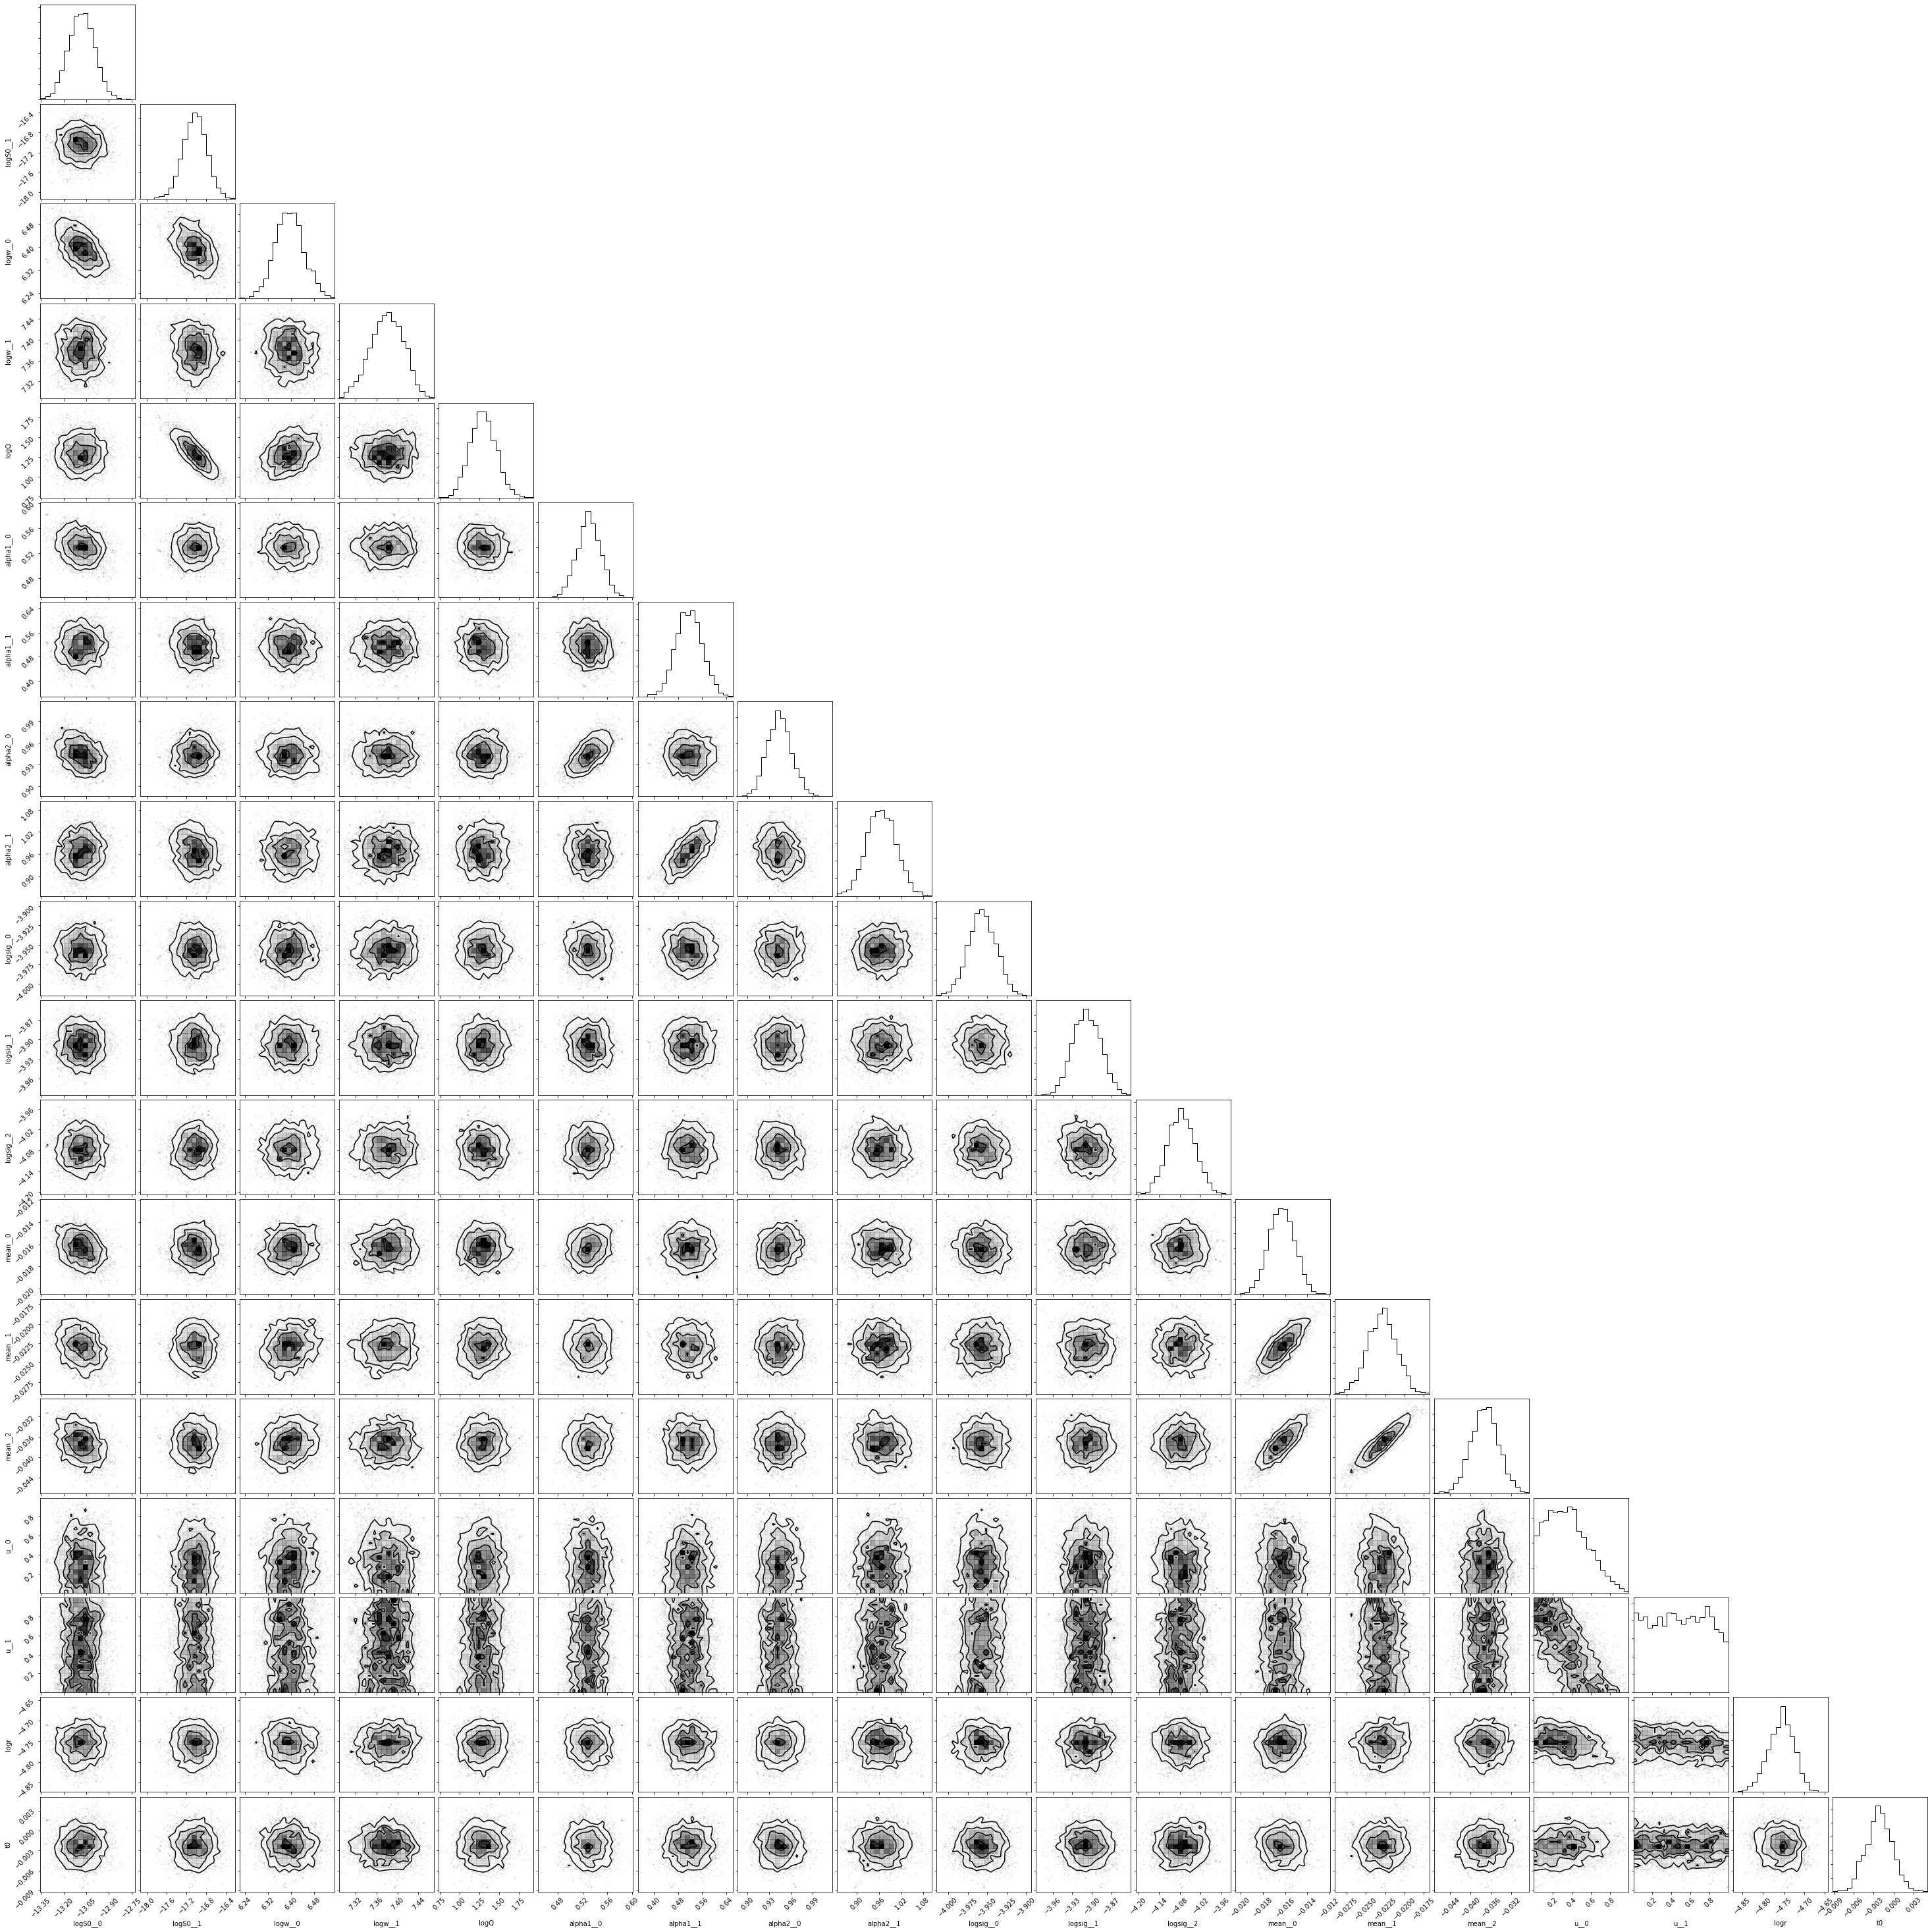

In [14]:
import corner
samples = pm.trace_to_dataframe(trace3)
_ = corner.corner(samples)

In [15]:
np.exp(-4.71)

0.00900477758243656

In [16]:
mean = (planet + moon)
obs = np.mean([r, g, b], axis=0) + mean

with pm.Model() as model:
    
    logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=2)
    logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=2)
    logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"])
    logsig = pm.Normal("logsig", mu=-4-np.log(3), sd=0.1)
    mean = pm.Normal("mean", mu=0.0, sd=0.1)
    u = MvUniform("u", lower=[0, 0], upper=[1, 1], testval=[0.5, 0.5])
    logr = pm.Uniform("logr", lower=-20.0, upper=0.0, testval=np.log(0.01))
    t0 = pm.Uniform("t0", lower=-1, upper=1, testval=0.0)
    
    orbit = xo.orbits.KeplerianOrbit(period=5.0)
    mean = (xo.LimbDarkLightCurve(u)
          .get_light_curve(orbit=orbit, r=tt.exp(logr), t=t-t0, texp=0.02)
          * 1e3).T
    
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = logQ
    )
        
    kernel = term1 + term2
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=4, mean=mean)
    gp.marginal("gp", observed = obs.T)
        
    start = model.test_point
    start["logr"] = np.log(0.01)
    start["t0"] = 0.0
    #map_soln = xo.optimize(start=start, verbose=True)
    #start = map_soln
    
    # comment this out if you don't want to run the mcmc right now.
    trace1 = pm.sample(
        tune=2000,
        draws=2000,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, logr, u, mean, logsig, logQ, logw, logS0]
Sampling 2 chains, 3,388 divergences: 100%|██████████| 8000/8000 [05:55<00:00, 22.50draws/

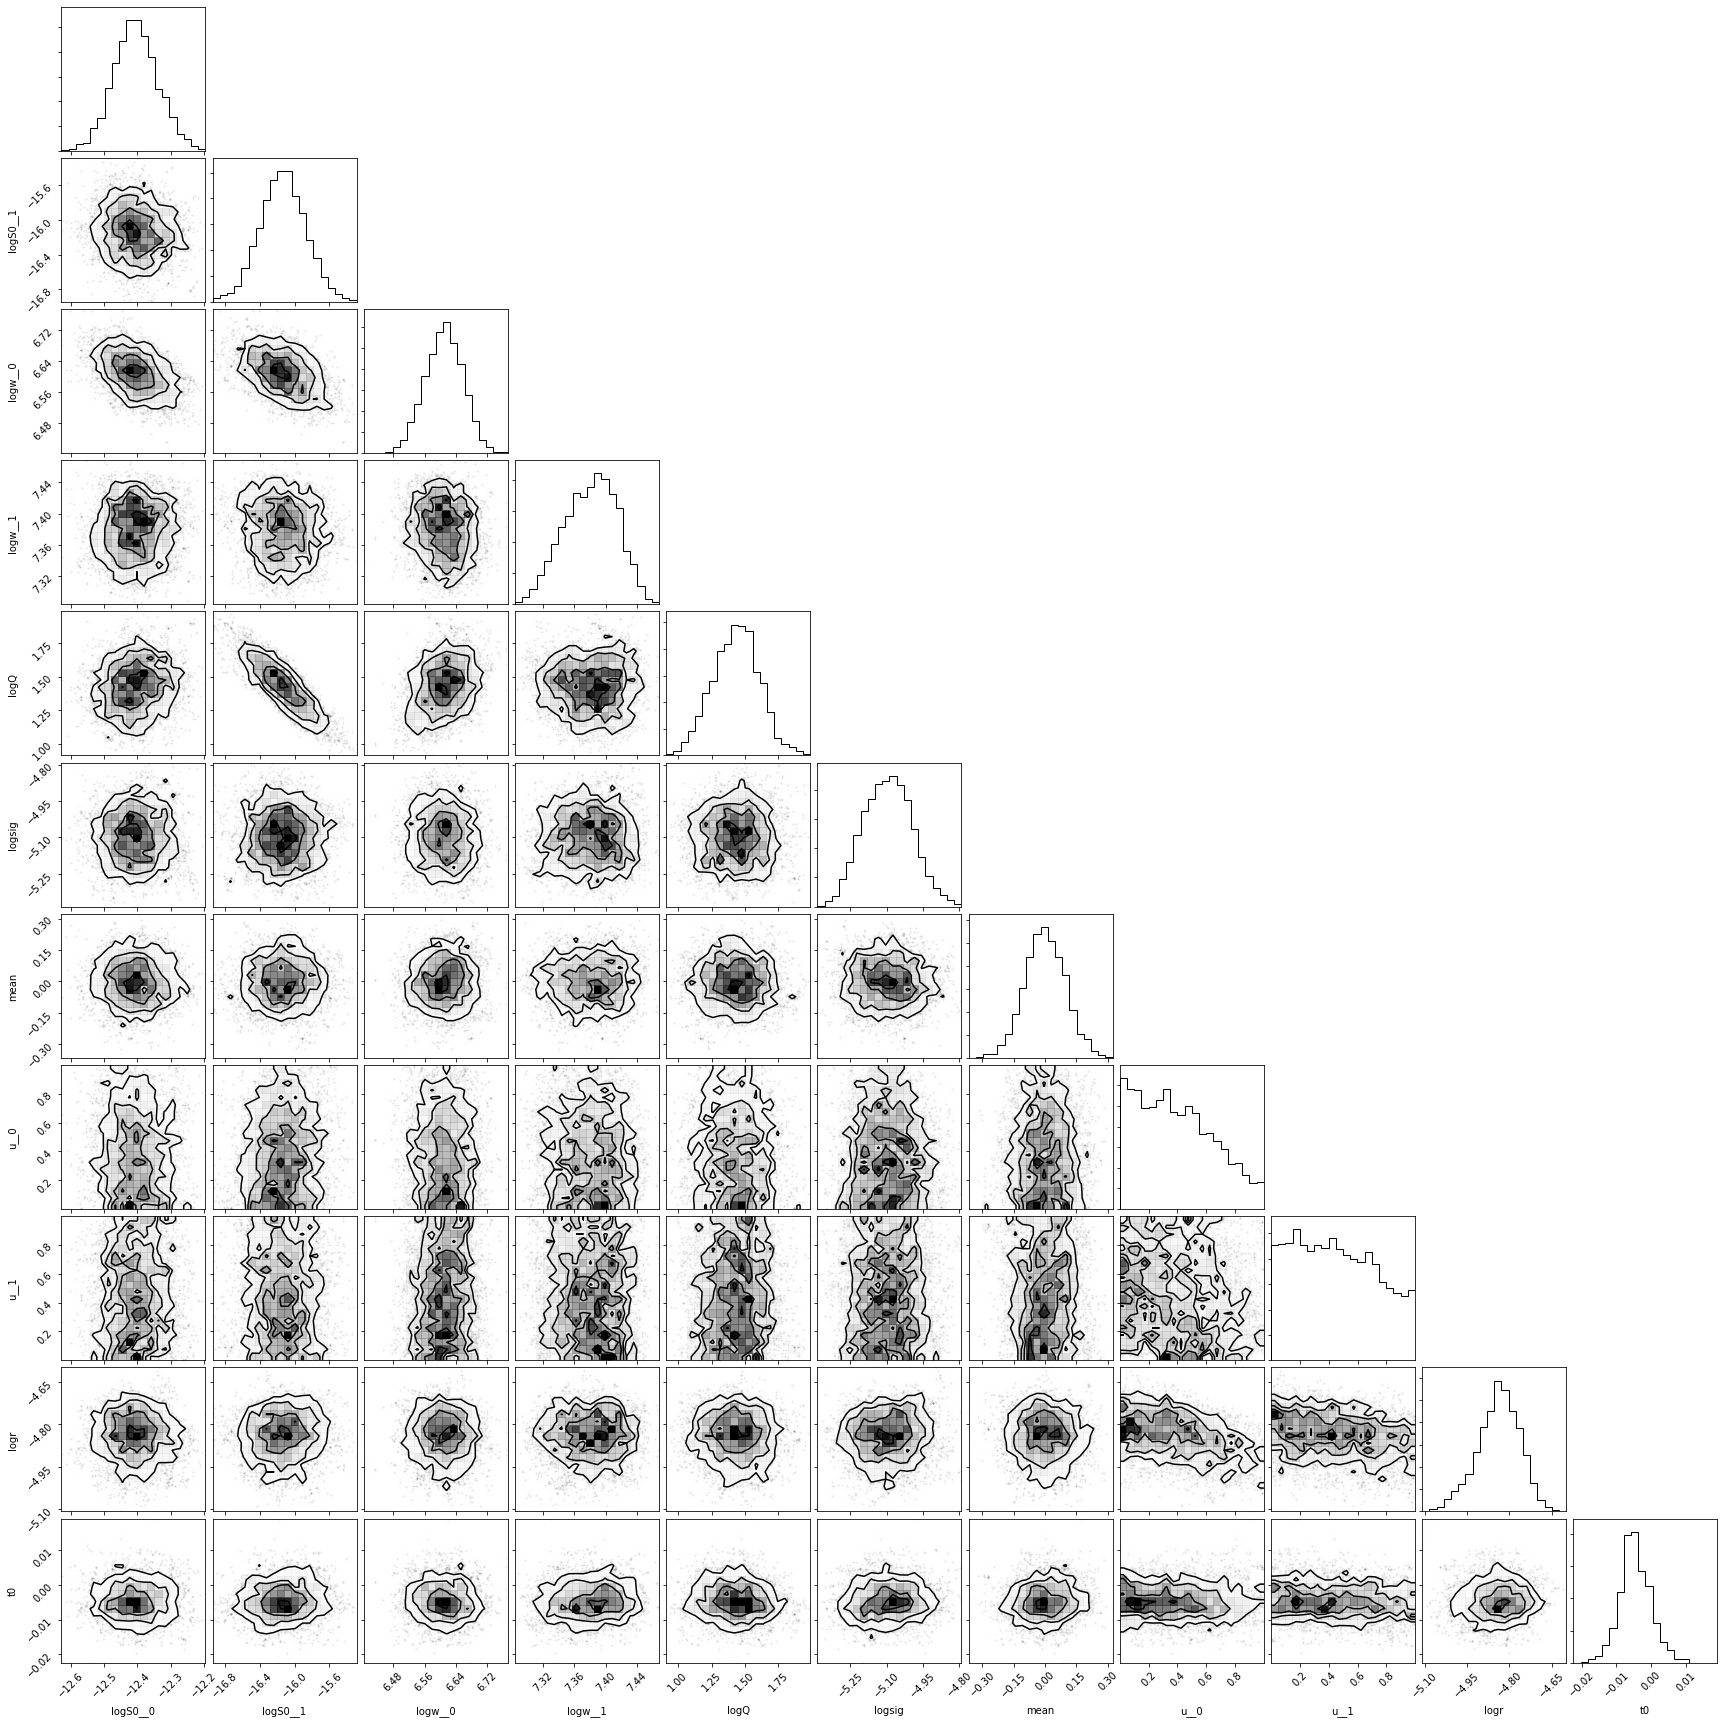

In [17]:
samples = pm.trace_to_dataframe(trace1)
_ = corner.corner(samples)

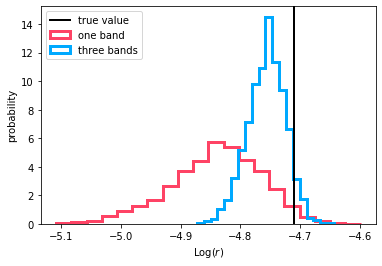

In [92]:
pl.hist(trace1.get_values('logr'), density=True, color=colors[0], 
        bins=20, histtype='step', linewidth=3, label="one band");
pl.hist(trace3.get_values('logr'), density=True, color=colors[2], 
        bins=20, histtype='step', linewidth=3, label="three bands");
pl.axvline(np.log(0.009), color='k', linewidth=2, label="true value")
pl.xlabel(r"$\mathrm{Log}(r)$")
pl.ylabel("probability")
pl.legend()

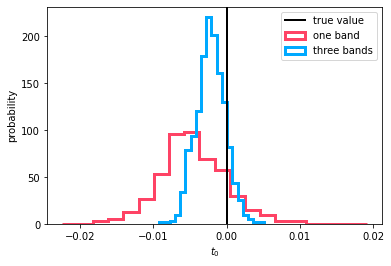

In [93]:
pl.hist(trace1.get_values('t0'), density=True, color=colors[0], 
        bins=20, histtype='step', linewidth=3, label="one band");
pl.hist(trace3.get_values('t0'), density=True, color=colors[2], 
        bins=20, histtype='step', linewidth=3, label="three bands");
pl.axvline(0, color='k', linewidth=2, label="true value")
pl.xlabel(r"$t_0$")
pl.ylabel("probability")
pl.legend()